In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes = (10,), eps = 1e-6):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers_len = len(hidden_layer_sizes) + 1
        self.eps = eps
        self.parameters = None  # W and b
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_y):
        W_arr = []
        b_arr = []
        self.dW = []
        self.db = []
        
        W1 = np.random.randn(n_y[0], n_x)*0.01;
        b1 = np.zeros((n_y[0], 1));
        W_arr.append(W1);
        b_arr.append(b1);
        
        for i in range(1,len(n_y)):
            W_temp =np.random.randn(n_y[i], n_y[i-1]) * 0.01;
            b_temp = np.zeros((n_y[i], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        W2 = np.random.randn(1, n_y[len(n_y)-1]) * 0.01
        b2 = 0
        
        W_arr.append(W2);
        b_arr.append(b2);
        
        self.parameters = {"W" : W_arr, "b" : b_arr}
        
       
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        Z = list()
        A = list()
        
        Z.append(np.dot(W[0], X) + b[0])
        A.append(self.__sigmoid(Z[0]))

        for i in range(1, self.layers_len):
            Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
            
        cache = (W, b, Z, A)
        return A[-1], cache
    
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None for i in range(self.layers_len)]
        db = [None for i in range(self.layers_len)]
        dZ = [None for i in range(self.layers_len)]
        dA = [None for i in range(self.layers_len)]
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.layers_len-1, 1, -1):
            dZ[i-1] = np.multiply(dA[i], np.multiply(A[i-1], 1 - A[i-1]))
            dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
            
        dZ[0] = np.multiply(dA[1], np.multiply(A[0], 1 - A[0]))
        dA[0] = np.dot(W[0].T, dZ[0])
        
        dW[0] = 1. / m * np.dot(dZ[0], X.T)
        db[0] = 1. / m * np.sum(dZ[0], axis = 1, keepdims = True)
    
        grads = {"dZ": dZ, "dW": dW, "db": db}
        return grads
    
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.layers_len):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]
        
        self.parameters = {"W": W, "b": b}

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_history = []
        m = X.shape[1]
        n_x = X.shape[0]
        self.__initialize_parameters(n_x, self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

Dataset 1

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


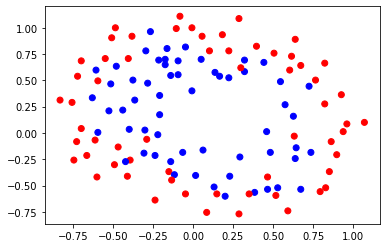

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000, hidden_layer_sizes=(20,), eps=1e-6)

0-th iteration: 0.6933937887642246
1000-th iteration: 0.6896332364743587
2000-th iteration: 0.5897471994261227
3000-th iteration: 0.3911883695829263


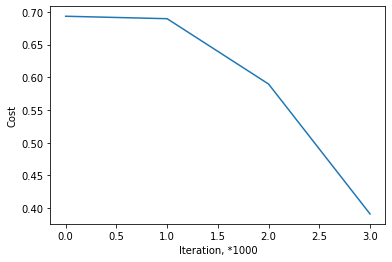

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W': [array([[ 0.91369092, -0.22004019],
       [ 1.28453085, -0.54727783],
       [ 0.08001666, -0.0925821 ],
       [-1.57671913, -0.45252596],
       [ 0.58641077,  0.00306399],
       [ 0.17971064, -0.07916079],
       [ 0.21697616, -0.06474215],
       [ 0.31326625,  0.00485421],
       [-0.89463284,  0.3379861 ],
       [ 1.91028387,  1.60559318],
       [ 0.10997748, -0.10953891],
       [ 0.25378548, -0.05815574],
       [-0.3902598 ,  2.74228374],
       [ 0.06194873, -0.1631824 ],
       [-0.2013841 ,  2.06659517],
       [ 0.25250975, -0.06462667],
       [ 0.20304459, -0.07015431],
       [-1.14309344, -0.09938863],
       [ 0.58568052,  1.31229486],
       [-0.59783597,  1.32114409]]), array([[ 0.777295  ,  3.65502236, -1.04901698, -3.32309558, -0.85764896,
        -0.8306262 , -0.79241279, -0.60379406, -1.6371424 , -8.84700046,
        -0.94982787, -0.76108301,  2.86886942, -1.02752058, -5.12614435,
        -0.7662121 , -0.80578473, -3.00035213,  3.79594192,  4.87723678]

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[5.80019382e-01, 4.19980618e-01],
       [8.09573684e-01, 1.90426316e-01],
       [3.55623156e-01, 6.44376844e-01],
       [1.78565901e-01, 8.21434099e-01],
       [8.63594745e-02, 9.13640525e-01],
       [8.82575003e-01, 1.17424997e-01],
       [3.42851220e-02, 9.65714878e-01],
       [3.17688254e-01, 6.82311746e-01],
       [7.89326223e-01, 2.10673777e-01],
       [9.49194505e-01, 5.08054952e-02],
       [9.80614859e-01, 1.93851412e-02],
       [2.53314407e-01, 7.46685593e-01],
       [2.43708990e-01, 7.56291010e-01],
       [1.22546192e-01, 8.77453808e-01],
       [8.02896718e-01, 1.97103282e-01],
       [2.01657790e-01, 7.98342210e-01],
       [6.25826868e-01, 3.74173132e-01],
       [8.16435786e-01, 1.83564214e-01],
       [7.63887378e-01, 2.36112622e-01],
       [1.48707082e-01, 8.51292918e-01],
       [9.95691722e-01, 4.30827815e-03],
       [8.66641045e-01, 1.33358955e-01],
       [8.37642754e-01, 1.62357246e-01],
       [6.89106778e-02, 9.31089322e-01],
       [2.803007

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [13]:
accuracy_score(Y, Y_hat)

0.847457627118644

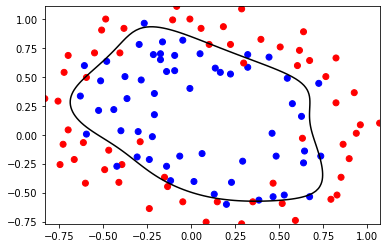

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

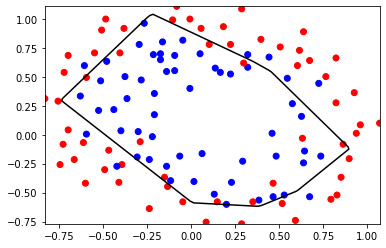

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576

In [19]:
clf.n_iter_

969

Dataset 2

In [20]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


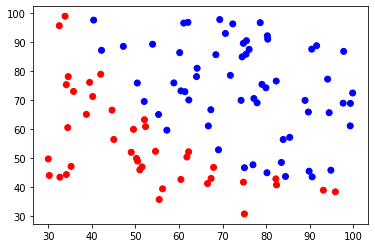

In [21]:
plot_data(X, Y)

In [22]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000, hidden_layer_sizes=(100,), eps=1e-6)

0-th iteration: 0.692238578477196
1000-th iteration: 0.6710523146471725
2000-th iteration: 0.5547412299106866
3000-th iteration: 0.25442955592018934


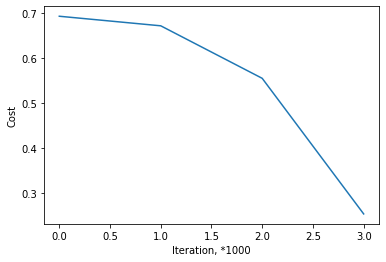

In [23]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [24]:
print(cls.parameters)

{'W': [array([[-0.12292946, -0.1185601 ],
       [ 0.27510277,  0.24339203],
       [-1.90464613, -1.66095148],
       [ 0.08502984,  0.04650261],
       [ 0.55687491,  0.49018864],
       [-1.54126034, -1.34484512],
       [ 1.61587831,  1.43406884],
       [ 0.3935223 ,  0.36480117],
       [ 1.28742302,  1.1266572 ],
       [ 1.76979302,  1.56817694],
       [-1.92409198, -1.68274824],
       [-0.23830179, -0.23572278],
       [-0.96492039, -0.85679671],
       [-0.65494079, -0.59072679],
       [ 0.92046422,  0.82113685],
       [ 0.45293279,  0.40959477],
       [ 1.06548316,  0.95882794],
       [-0.36669963, -0.32326446],
       [-2.33635475, -2.05418976],
       [-0.61759501, -0.54664201],
       [-2.02620419, -1.78884971],
       [-0.15072455, -0.14182181],
       [ 1.21134918,  1.09050719],
       [-1.30167358, -1.14564178],
       [-1.01594221, -0.90715917],
       [-2.50079347, -2.19961628],
       [-0.53578865, -0.47583157],
       [-1.05459856, -0.91777753],
       [-1.32

In [25]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[1.69593466e-01, 8.30406534e-01],
       [1.09434126e-03, 9.98905659e-01],
       [1.07587060e-01, 8.92412940e-01],
       [9.59823007e-01, 4.01769930e-02],
       [9.87154406e-01, 1.28455936e-02],
       [4.41812137e-02, 9.55818786e-01],
       [9.90980680e-01, 9.01932022e-03],
       [4.56917160e-01, 5.43082840e-01],
       [9.96220244e-01, 3.77975620e-03],
       [6.78816377e-01, 3.21183623e-01],
       [8.37903743e-01, 1.62096257e-01],
       [8.64861034e-02, 9.13513897e-01],
       [9.93032030e-01, 6.96797039e-03],
       [9.97592902e-01, 2.40709755e-03],
       [2.37837006e-01, 7.62162994e-01],
       [9.36430112e-01, 6.35698883e-02],
       [4.57759177e-01, 5.42240823e-01],
       [2.38795191e-01, 7.61204809e-01],
       [9.96158574e-01, 3.84142603e-03],
       [5.60877749e-01, 4.39122251e-01],
       [1.46028562e-01, 8.53971438e-01],
       [9.89464173e-01, 1.05358270e-02],
       [3.48278192e-02, 9.65172181e-01],
       [1.96301020e-03, 9.98036990e-01],
       [9.648851

In [26]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [27]:
accuracy_score(Y, Y_hat)

0.89

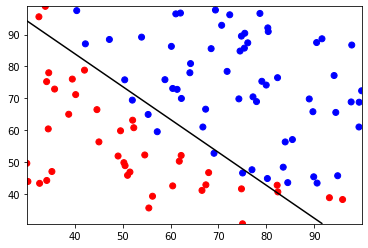

In [28]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [29]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (650,), max_iter = 10000, activation = 'tanh', solver = 'sgd', learning_rate_init = 0.0005, learning_rate = 'constant')

In [30]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(650,),
              learning_rate_init=0.0005, max_iter=10000, solver='sgd')

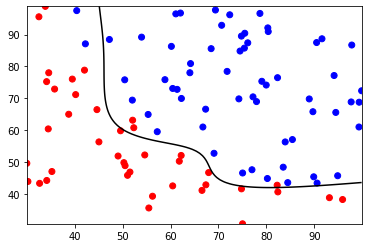

In [31]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [32]:
accuracy_score(Y, clf.predict(X))

0.95